In [60]:
import pandas as pd

In [79]:
data = pd.read_csv('cleaned_data_pangan.csv')
data.head()

,Tanggal,Beras,Beras Kualitas Bawah I (kg),Beras Kualitas Bawah II (kg),Beras Kualitas Medium I (kg),Beras Kualitas Medium II (kg),Beras Kualitas Super I (kg),Beras Kualitas Super II (kg),Bawang Merah,Bawang Merah Ukuran Sedang (kg),Bawang Putih,Bawang Putih Ukuran Sedang (kg),Cabai Merah,Cabai Merah Besar (kg),Cabai Merah Keriting (kg),Cabai Rawit,Cabai Rawit Hijau (kg),Cabai Rawit Merah (kg)
0,2017-07-31,11200.0,10150.0,9650.0,11250.0,11150.0,12750.0,12250.0,33500.0,33500.0,33450.0,33450.0,31700.0,32050.0,31400.0,41600.0,34750.0,48700.0
1,2017-08-01,11200.0,10150.0,9650.0,11250.0,11150.0,12750.0,12250.0,33200.0,33200.0,33350.0,33350.0,32000.0,32250.0,31500.0,41050.0,34800.0,47550.0
2,2017-08-02,11200.0,10150.0,9650.0,11250.0,11150.0,12750.0,12250.0,32950.0,32950.0,33150.0,33150.0,32200.0,32700.0,31800.0,40600.0,34600.0,46650.0
3,2017-08-03,11200.0,10150.0,9650.0,11250.0,11150.0,12700.0,12250.0,32650.0,32650.0,33150.0,33150.0,32400.0,33050.0,31850.0,40350.0,34650.0,46050.0
4,2017-08-04,11300.0,10150.0,10300.0,11250.0,11150.0,12750.0,12250.0,32150.0,32150.0,33000.0,33000.0,32250.0,33150.0,31550.0,40500.0,34600.0,46550.0


In [3]:
data['Tanggal'] = pd.to_datetime(data['Tanggal'], infer_datetime_format=True)

In [4]:
data.columns = data.columns.str.replace(' ' , '_')

In [5]:
df1=data.reset_index()['Bawang_Merah']

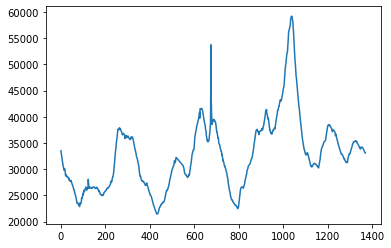

In [6]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [61]:
import numpy as np

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [9]:
training_size,test_size

(890, 480)

In [10]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [11]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
print(X_train.shape), print(y_train.shape)

(789, 100)
(789,)


(None, None)

In [13]:
print(X_test.shape), print(ytest.shape)

(379, 100)
(379,)


(None, None)

In [14]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [15]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [39]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                 patience=3,
                                                 mode='min')

model.compile(loss=tf.losses.MeanSquaredError(), 
              optimizer='adam', 
             metrics = [tf.metrics.MeanAbsoluteError()])

history = model.fit(X_train,y_train, epochs = 50,
                    validation_data = (X_test,ytest),                    
                    shuffle = False,
                    batch_size = 64,
                    verbose = 1,
                    callbacks=[early_stopping])

Epoch 1/50
13/13 [==============================] - 5s 422ms/step - loss: 0.0164 - mean_absolute_error: 0.1007 - val_loss: 0.0242 - val_mean_absolute_error: 0.1012
Epoch 2/50
13/13 [==============================] - 3s 232ms/step - loss: 0.0060 - mean_absolute_error: 0.0606 - val_loss: 0.0083 - val_mean_absolute_error: 0.0738
Epoch 3/50
13/13 [==============================] - 3s 229ms/step - loss: 0.0057 - mean_absolute_error: 0.0626 - val_loss: 0.0056 - val_mean_absolute_error: 0.0548
Epoch 4/50
13/13 [==============================] - 3s 227ms/step - loss: 0.0036 - mean_absolute_error: 0.0482 - val_loss: 0.0055 - val_mean_absolute_error: 0.0525
Epoch 5/50
13/13 [==============================] - 3s 227ms/step - loss: 0.0026 - mean_absolute_error: 0.0396 - val_loss: 0.0051 - val_mean_absolute_error: 0.0472
Epoch 6/50
13/13 [==============================] - 3s 229ms/step - loss: 0.0020 - mean_absolute_error: 0.0328 - val_loss: 0.0033 - val_mean_absolute_error: 0.0350
Epoch 7/50
13/13

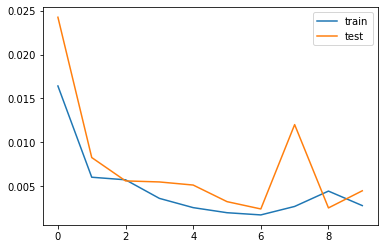

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [20]:
import tensorflow as tf

In [21]:
tf.__version__

'2.3.1'

In [43]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [44]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [45]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

30063.746746028923

In [46]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

36768.97321593936

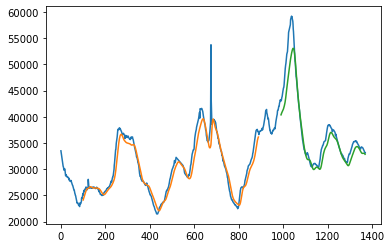

In [47]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
len(test_data)

480

In [49]:
x_input=test_data[380:].reshape(1,-1)
x_input.shape

(1, 100)

In [50]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [51]:
temp_input

[0.2900662251655629,
 0.2887417218543046,
 0.2847682119205298,
 0.28079470198675494,
 0.27682119205298017,
 0.2781456953642384,
 0.2794701986754967,
 0.27152317880794696,
 0.27019867549668874,
 0.26843267108167757,
 0.26666666666666683,
 0.26490066225165565,
 0.2635761589403973,
 0.2609271523178808,
 0.2622516556291391,
 0.25960264900662255,
 0.25960264900662255,
 0.25960264900662255,
 0.25960264900662255,
 0.2622516556291391,
 0.2728476821192053,
 0.28079470198675494,
 0.2850993377483444,
 0.28940397350993374,
 0.2937086092715232,
 0.29801324503311255,
 0.2993377483443709,
 0.304635761589404,
 0.30331125827814565,
 0.3019867549668874,
 0.3059602649006622,
 0.30993377483443707,
 0.31390728476821195,
 0.31920529801324504,
 0.3231788079470198,
 0.32582781456953636,
 0.328476821192053,
 0.33200883002207515,
 0.33554083885209707,
 0.3390728476821192,
 0.34304635761589397,
 0.3496688741721854,
 0.35231788079470194,
 0.3536423841059603,
 0.3571743929359824,
 0.3607064017660043,
 0.3642384105

In [52]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.298335]
101
1 day input [0.28874172 0.28476821 0.2807947  0.27682119 0.2781457  0.2794702
 0.27152318 0.27019868 0.26843267 0.26666667 0.26490066 0.26357616
 0.26092715 0.26225166 0.25960265 0.25960265 0.25960265 0.25960265
 0.26225166 0.27284768 0.2807947  0.28509934 0.28940397 0.29370861
 0.29801325 0.29933775 0.30463576 0.30331126 0.30198675 0.30596026
 0.30993377 0.31390728 0.3192053  0.32317881 0.32582781 0.32847682
 0.33200883 0.33554084 0.33907285 0.34304636 0.34966887 0.35231788
 0.35364238 0.35717439 0.3607064  0.36423841 0.36556291 0.36423841
 0.36556291 0.36688742 0.36732892 0.36777042 0.36821192 0.36821192
 0.36821192 0.36556291 0.36953642 0.36865342 0.36777042 0.36688742
 0.3615894  0.3615894  0.3589404  0.35629139 0.35452539 0.35275938
 0.35099338 0.34966887 0.34701987 0.34304636 0.34072848 0.3384106
 0.33609272 0.33377483 0.33377483 0.32980132 0.32847682 0.32847682
 0.33200883 0.33554084 0.33907285 0.33774834 0.33774834 0.33774834
 0.33642384 0.33554084 0.33465784 0.3

8 day output [[0.2789861]]
9 day input [0.26843267 0.26666667 0.26490066 0.26357616 0.26092715 0.26225166
 0.25960265 0.25960265 0.25960265 0.25960265 0.26225166 0.27284768
 0.2807947  0.28509934 0.28940397 0.29370861 0.29801325 0.29933775
 0.30463576 0.30331126 0.30198675 0.30596026 0.30993377 0.31390728
 0.3192053  0.32317881 0.32582781 0.32847682 0.33200883 0.33554084
 0.33907285 0.34304636 0.34966887 0.35231788 0.35364238 0.35717439
 0.3607064  0.36423841 0.36556291 0.36423841 0.36556291 0.36688742
 0.36732892 0.36777042 0.36821192 0.36821192 0.36821192 0.36556291
 0.36953642 0.36865342 0.36777042 0.36688742 0.3615894  0.3615894
 0.3589404  0.35629139 0.35452539 0.35275938 0.35099338 0.34966887
 0.34701987 0.34304636 0.34072848 0.3384106  0.33609272 0.33377483
 0.33377483 0.32980132 0.32847682 0.32847682 0.33200883 0.33554084
 0.33907285 0.33774834 0.33774834 0.33774834 0.33642384 0.33554084
 0.33465784 0.33377483 0.33112583 0.32847682 0.32450331 0.32317881
 0.3200883  0.31699779 0

16 day output [[0.25823963]]
17 day input [0.25960265 0.25960265 0.26225166 0.27284768 0.2807947  0.28509934
 0.28940397 0.29370861 0.29801325 0.29933775 0.30463576 0.30331126
 0.30198675 0.30596026 0.30993377 0.31390728 0.3192053  0.32317881
 0.32582781 0.32847682 0.33200883 0.33554084 0.33907285 0.34304636
 0.34966887 0.35231788 0.35364238 0.35717439 0.3607064  0.36423841
 0.36556291 0.36423841 0.36556291 0.36688742 0.36732892 0.36777042
 0.36821192 0.36821192 0.36821192 0.36556291 0.36953642 0.36865342
 0.36777042 0.36688742 0.3615894  0.3615894  0.3589404  0.35629139
 0.35452539 0.35275938 0.35099338 0.34966887 0.34701987 0.34304636
 0.34072848 0.3384106  0.33609272 0.33377483 0.33377483 0.32980132
 0.32847682 0.32847682 0.33200883 0.33554084 0.33907285 0.33774834
 0.33774834 0.33774834 0.33642384 0.33554084 0.33465784 0.33377483
 0.33112583 0.32847682 0.32450331 0.32317881 0.3200883  0.31699779
 0.31390728 0.31258278 0.31125828 0.30860927 0.30860927 0.29833499
 0.29637527 0.294238

24 day output [[0.23982064]]
25 day input [0.29801325 0.29933775 0.30463576 0.30331126 0.30198675 0.30596026
 0.30993377 0.31390728 0.3192053  0.32317881 0.32582781 0.32847682
 0.33200883 0.33554084 0.33907285 0.34304636 0.34966887 0.35231788
 0.35364238 0.35717439 0.3607064  0.36423841 0.36556291 0.36423841
 0.36556291 0.36688742 0.36732892 0.36777042 0.36821192 0.36821192
 0.36821192 0.36556291 0.36953642 0.36865342 0.36777042 0.36688742
 0.3615894  0.3615894  0.3589404  0.35629139 0.35452539 0.35275938
 0.35099338 0.34966887 0.34701987 0.34304636 0.34072848 0.3384106
 0.33609272 0.33377483 0.33377483 0.32980132 0.32847682 0.32847682
 0.33200883 0.33554084 0.33907285 0.33774834 0.33774834 0.33774834
 0.33642384 0.33554084 0.33465784 0.33377483 0.33112583 0.32847682
 0.32450331 0.32317881 0.3200883  0.31699779 0.31390728 0.31258278
 0.31125828 0.30860927 0.30860927 0.29833499 0.29637527 0.29423806
 0.29193756 0.28949967 0.28695533 0.28433645 0.28167188 0.2789861
 0.27629888 0.27362484

In [53]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [54]:
import matplotlib.pyplot as plt

In [55]:
len(df1)

1370

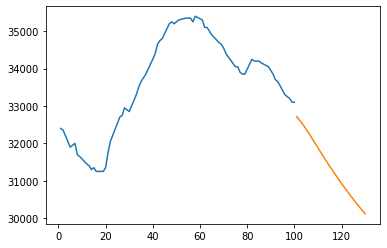

In [56]:
plt.plot(day_new,scaler.inverse_transform(df1[1270:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

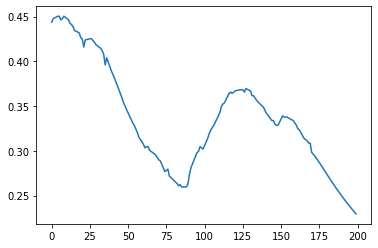

In [57]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [58]:
df3=scaler.inverse_transform(df3).tolist()

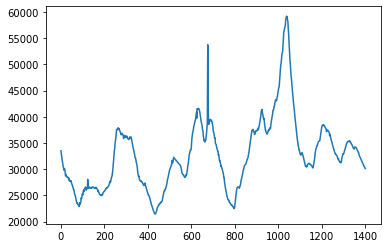

In [59]:
plt.plot(df3)

In [68]:
df3['+prediction'] = pd.DataFrame(df3)

In [77]:
df3.drop(0, inplace = True, axis = 1)

In [78]:
df3

,+prediction
0,33500.000000
1,33200.000000
2,32950.000000
3,32650.000000
4,32150.000000
...,...
1395,30422.541619
1396,30343.207338
1397,30265.222539
1398,30188.571472


In [93]:
df3.shape[0]

1400

In [91]:
df3['Date'] = pd.date_range(start = '2017-07-31', periods = df3.shape[0],freq ='D')

In [92]:
df3

,+prediction,Date
0,33500.000000,2017-07-31
1,33200.000000,2017-08-01
2,32950.000000,2017-08-02
3,32650.000000,2017-08-03
4,32150.000000,2017-08-04
...,...,...
1395,30422.541619,2021-05-26
1396,30343.207338,2021-05-27
1397,30265.222539,2021-05-28
1398,30188.571472,2021-05-29


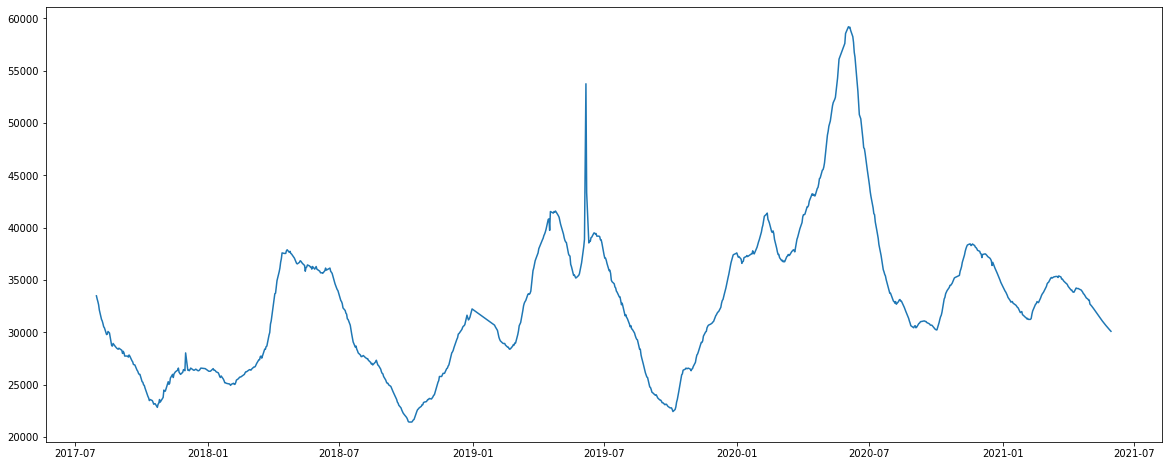

In [100]:
plt.figure(figsize= (20,8))
plt.plot(df3['Date'], df3['+prediction'])
plt.show()